In [1]:
import requests as rq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from nltk.metrics.distance import jaccard_distance

### Part 1. Define function for querying datamuse.

In [19]:

def query_datamuse(word, n=100):
    query = "https://api.datamuse.com/words?ml={}&max={}".format(word, n)
    response = rq.get(query)
    results = []
    for obj in response.json(): 
        results.append(obj["word"])
    return results

In [6]:
#Load datasets 
mc = pd.read_csv("data/mc.csv", header=0, names=["word1", "word2", "score"], sep=";")
rg = pd.read_csv("data/rg.csv", header=0, names=["word1", "word2", "score"], sep=";")
wordsim = pd.read_csv("data/wordsim.csv", header=0, names=["word1", "word2", "score"], sep=";")

### Part 2. Define functions for calculating jaccard similarity from dataset.

In [16]:
def jaccard_similarity(set1, set2): 
    return 1 - jaccard_distance(set1, set2)

def datamuse_similarity(X, Y, n=100):
    words1 = query_datamuse(X, n=n)
    words2 = query_datamuse(Y, n=n)    
    return jaccard_similarity(set(words1), set(words2))

def calculate_similarities(df, n): 
    words1 = df["word1"].tolist()
    words2 = df["word2"].tolist()
    scores = df["score"].tolist()

    sim_values = []
    for w1, w2 in zip(words1, words2): 
        sim_values.append(datamuse_similarity(w1, w2, n=n))
        
    p = stats.pearsonr(sim_values, scores)
    return p



Time taken:  0.6019880771636963
Time taken:  0.594282865524292
Time taken:  0.5818297863006592
Time taken:  0.5821528434753418
Time taken:  0.5940790176391602
Time taken:  0.5950262546539307
Time taken:  0.5765759944915771
Time taken:  0.5760419368743896
Time taken:  0.5662791728973389
Time taken:  0.5791428089141846
Time taken:  0.5712110996246338
Time taken:  0.5902116298675537
Time taken:  0.5843372344970703
Time taken:  0.5729200839996338
Time taken:  0.5776190757751465
Time taken:  0.5791449546813965
Time taken:  0.5816760063171387
Time taken:  0.584118127822876
Time taken:  0.5905230045318604
Time taken:  0.5854928493499756
Time taken:  0.9760861396789551
Time taken:  0.5864808559417725
Time taken:  0.5792019367218018
Time taken:  0.5759091377258301
Time taken:  0.5844087600708008
Time taken:  0.5801489353179932
Time taken:  0.5765187740325928
Time taken:  0.5743331909179688
Time taken:  0.5707650184631348
Time taken:  0.5839660167694092
Time taken:  0.5842759609222412
Time taken

PearsonRResult(statistic=0.619798204105011, pvalue=0.0003360473903788395)

In [ ]:
calculate_similarities(mc, 100)

### Find the N with highest Pearson correlation coefficient score.

In [17]:
def find_best_n(df): 
    d = {
        "n": [],
        "statistics": [],
        "pvalues": []
    }
    stats = []
    pvals = []
    for n in range(100, 1000, 100): 
        print("N: {}".format(n))
        p = calculate_similarities(mc, n)
        d["n"].append(n)
        d["statistics"].append(p.statistic)
        d["pvalues"].append(p.pvalue)
    
    return d

d = find_best_n(mc)
df = pd.DataFrame.from_dict(d)

N: 100
Time taken:  0.5967061519622803
Time taken:  0.5760378837585449
Time taken:  0.5807070732116699
Time taken:  0.582355260848999
Time taken:  0.5941898822784424
Time taken:  0.6152689456939697
Time taken:  0.5872769355773926
Time taken:  0.5841343402862549
Time taken:  0.5762331485748291
Time taken:  0.5747969150543213
Time taken:  0.5901408195495605
Time taken:  0.5974979400634766
Time taken:  0.5697710514068604
Time taken:  0.589536190032959
Time taken:  0.5974252223968506
Time taken:  0.5832550525665283
Time taken:  0.744318962097168
Time taken:  0.5818390846252441
Time taken:  0.5928778648376465
Time taken:  0.5877060890197754
Time taken:  0.6145801544189453
Time taken:  0.6168580055236816
Time taken:  0.5804319381713867
Time taken:  0.583158016204834
Time taken:  0.5847060680389404
Time taken:  0.5840730667114258
Time taken:  0.6074299812316895
Time taken:  0.5818192958831787
Time taken:  0.5807201862335205
Time taken:  0.5932018756866455
Time taken:  0.5912830829620361
Time 

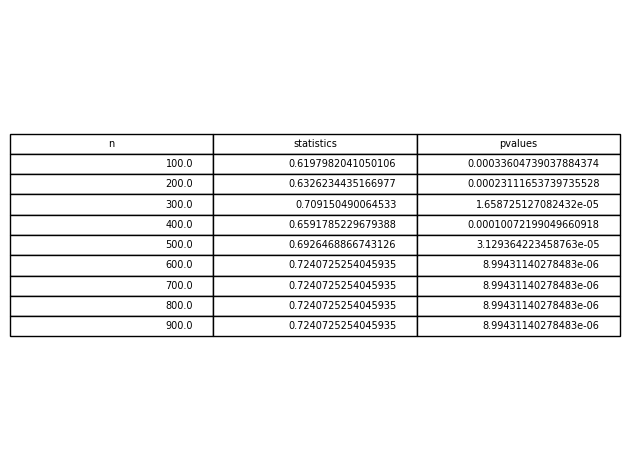

In [6]:
fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
fig.tight_layout()
plt.show()

In [10]:
# Get the N value with highest Pearson correlation coefficient score
max_id = df['statistics'].idxmax()
N = int(df.iloc[max_id]["n"])
print(N)

600


### Calculate correlation coefficients for all datasets.

In [11]:
p_mc = calculate_similarities(mc, N)
p_rg = calculate_similarities(rg, N)
p_wordsim = calculate_similarities(wordsim, N)
print(p_mc)
print(p_rg)
print(p_wordsim)

Time taken:  0.6451568603515625
Time taken:  0.5897772312164307
Time taken:  0.612558126449585
Time taken:  0.5855858325958252
Time taken:  0.5943543910980225
Time taken:  0.5803768634796143
Time taken:  0.586665153503418
Time taken:  0.5797929763793945
Time taken:  0.5718700885772705
Time taken:  0.5725820064544678
Time taken:  0.5850448608398438
Time taken:  0.5930519104003906
Time taken:  0.5711262226104736
Time taken:  0.568234920501709
Time taken:  0.5951240062713623
Time taken:  0.7355899810791016
Time taken:  0.5835731029510498
Time taken:  0.5850889682769775
Time taken:  0.5815210342407227
Time taken:  0.5744838714599609
Time taken:  0.5905389785766602
Time taken:  0.5731518268585205
Time taken:  0.5854780673980713
Time taken:  0.5760278701782227
Time taken:  0.59722900390625
Time taken:  0.5788021087646484
Time taken:  0.5868837833404541
Time taken:  0.5700480937957764
Time taken:  0.566551923751831
Time taken:  0.5774292945861816
Time taken:  0.604135274887085
Time taken:  0.

# Part 3 - Apply the method in part 2 on sentence level

In [13]:
# get sentence bag of similartities words

def get_bag_of_words(sentence): 
    words = sentence.split(" ")
    bag = set(words)
    for word in words: 
        bag = bag.union(set(query_datamuse(word, n=N)))
    return bag

def get_sentence_similarity(sentence1, sentence2):
    bag1 = get_bag_of_words(sentence1)
    bag2 = get_bag_of_words(sentence2)
    return jaccard_similarity(bag1, bag2)

# Part 4

In [14]:
sentence_pairs_list = [
    ["Today is quite hot for a winter.", "Never is warm in winter."],
    ["The car is running fast but has some troubles recently.", "Toyota cars are recalled for a fault."],
    ["The teacher cannot do it again and never again.", "Teacher has been prohibited from this task."]
]

In [21]:
results = []
for pair in sentence_pairs_list: 
    results.append(get_sentence_similarity(pair[0], pair[1]))

# create a table
d = {
    "sentence1": [x[0] for x in sentence_pairs_list],
    "sentence2": [x[1] for x in sentence_pairs_list],
    "similarity": results
}

df = pd.DataFrame.from_dict(d)
df